# Sink-source connectivity for decoding neural correlates of behavior

Applying the sink-source connectivity biomarker for analyzing neural correlates of behavior

In [1]:
import h5py 
import mat73
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import mne
import re

## Load Data

In [2]:
# ncsl_share = '/run/user/1000/gvfs/smb-share:server=10.162.37.21,share=main'
# data_path = f'Data/Subject06_snapshot_normalized.npy'
subs = ['07']
file_paths = {}

for sub in subs:
    # create a dictionary holding the file paths
    ncsl_share = '/mnt/ncsl_share'
    file_paths[sub] = {
        'setup_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Setup.mat',
        'raw_path': ncsl_share + f'/Public/EFRI/1_formatted/SUBJECT{sub}/EFRI{sub}_WAR_SES1_Raw.mat',
        # 'data_path': ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/Subject{sub}_snapshot_normalized.npy', # movement onset as event
        # 'data_path' : ncsl_share + f'/Daniel/Data/Trial_by_Chan_by_Freq_by_Time_Snapshots/show-card_pre-2sec_post-4sec/Subject{sub}_snapshot_normalized.npy', # visual cue as event
    }

In [3]:
raw_file = h5py.File(file_paths[subs[0]]['raw_path'])
setup_data = mat73.loadmat(file_paths[subs[0]]['setup_path'])

In [4]:
elec_names = np.array(setup_data['elec_name'])
elec_areas = np.array(setup_data['elec_area'])

In [5]:
filtered_elec_areas_idxs = [i for i,ea in enumerate(elec_areas) if ea not in 
                            ['white matter','CZ','PZ', 'out','FZ','cerebrospinal fluid',
                                'lesion L','ventricle L','ventricle R']]
filtered_elec_areas = [elec_areas[i] for i in filtered_elec_areas_idxs]
filtered_elec_names = [elec_names[i] for i in filtered_elec_areas_idxs]
filtered_num_channels = len(filtered_elec_areas_idxs)

# Data preprocessing

In [6]:
Fs = raw_file['Fs'][0][0]
lfp_data = raw_file['lfpdata']
lfp_all = lfp_data[:,:]

# Filter Data Bandpass .5-200 Hz 
filt = mne.filter.filter_data(lfp_all,Fs,0.5,200,method="iir")
# notch filter 60 hz harmonics
for notchfreq in [60,120,180]:
    filt = mne.filter.notch_filter(filt,Fs,notchfreq, method="iir")
# decimate to 500 Hz 
decFactor = int(Fs/500)
filt = filt[:,::decFactor]

## For each channel in elec_names, get its index position in array, whether its on the end of the electrode shaft, and its neighboring indices 
lap_ref_data = np.zeros(filt.shape)
for i,en in enumerate(elec_names):
    if en in ["REF1","REF2","E","CZ","FZ","PZ"]:
        lap_ref_data[i,:] = filt[i,:]
        continue
    pattern = r"([a-z']+) *(\d+)"
    shaft_name = re.findall(pattern,en,re.IGNORECASE)[0][0]
    elec_num = re.findall(pattern,en,re.IGNORECASE)[0][1]
    en_plus1 = f"{shaft_name}{str(int(elec_num)+1)}"
    en_minus1 = f"{shaft_name}{str(int(elec_num)-1)}"
    if en_minus1 not in elec_names:
        neighbor_inds=[i-1]
    elif en_plus1 not in elec_names:
        neighbor_inds=[i+1]
    else:
        neighbor_inds = [ i-1,i+1]
    print(en, i, neighbor_inds,[elec_names[n] for n in neighbor_inds])
    neighbor_mean = np.mean(filt[neighbor_inds,:],axis=0)
    lap_ref_data[i,:] = filt[i,:] - neighbor_mean

Setting up band-pass filter from 0.5 - 2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 200.00 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 59 - 61 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 59.35, 60.65 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.2e+02 - 1.2e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 119.20, 120.80 Hz: -6.02, -6.02 dB

Setting up band-stop filter from 1.8e+02 - 1.8e+02 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-ca

In [7]:
lfp_all.shape

(133, 3644000)

In [8]:
Fs

2000.0

In [9]:
dsFs = 500 #downsample FS is 500 Hz 
good_trials = setup_data['filters']['trial'][setup_data['filters']['success']].astype(int)-1
num_trials = len(good_trials)
snapshot_data = np.zeros((num_trials,lap_ref_data.shape[0],int(5*dsFs)))
onset_delay = 3.0

# Snapshot around movement onset (-3 sec to +2 sec)
for i,t in enumerate(good_trials):
    start_move_time = setup_data['trial_times'][t][0][setup_data['trial_words'][t][0]==35][0]
    #print(f'start move time = {start_move_time} for trial {t}')
    
    ## To go from the time to the index position in the lfp array, multiply time by Fs 
    start_move_index = int(start_move_time*dsFs)
    #print(f'start move index = {start_move_index} for trial {t}')
    start_index = int((start_move_time - onset_delay)*dsFs)
    end_index = start_index+int(5*dsFs)#int((start_move_time + 2.0)*Fs)
    data_slice = lap_ref_data[:,start_index:end_index]
    snapshot_data[i,:,:] = data_slice

In [10]:
unfiltered_bets = setup_data['filters']['bets']

good_trials = np.where(np.isnan(unfiltered_bets) == False)[0] # extract indices of trials without the 'nan'

bets = unfiltered_bets[good_trials] # get the bet values for the good trials
subject_cards = setup_data['filters']['card1'][good_trials] # get the subject's card values for the good trials

data = snapshot_data[:,filtered_elec_areas_idxs,:]
y = np.asarray([(0 if bet == 5 else 1) for bet in bets])

In [11]:
high_bet_trials = np.where(y == 1)[0]
low_bet_trials = np.where(y == 0)[0]

# Compute A Matrices

In [12]:
data.shape

(162, 75, 2500)

In [13]:
def estimateA(X):
    # Jeff Craley's Method using definition of least squares
    Y = X[:, 1:]
    Z = X[:, 0:-1]
    A_hat = Y @ np.linalg.pinv(Z)
    return A_hat

def estimateA_subject(data, fs=500, winsize=0.2):
    window = int(np.floor(winsize * fs))
    time = data.shape[1]
    n_chs = data.shape[0]
    n_wins = int(np.round(time / window))
    A_hat = np.zeros((n_chs, n_chs, n_wins))
    for win in range(0,n_wins):
        if win*window < data.shape[1]:
            data_win = data[:,win*window:(win+1)*window]
            A_hat[:,:,win] = estimateA(data_win)
            if win % 1000 == 0:
                print(f"{win}/{n_wins} is computed")
    return A_hat

In [14]:
A_hat_all = []

for i in range(data.shape[0]):
    A_hat_all.append(estimateA_subject(data[i,:,:]))

0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is computed
0/25 is comput

In [15]:
A_hat_all = np.asarray(A_hat_all)
A_hat_all.shape

(162, 75, 75, 25)

In [16]:
window_length = data.shape[2]/dsFs
num_timesteps = A_hat_all.shape[3]
time = np.linspace(0,window_length,num_timesteps) - onset_delay
time = [round(i, 2) for i in time]

# Compute Sink Indices

## Define sink index function

In [28]:
def identifySS(A):
    nCh = A.shape[0]

    A_abs = np.abs(A)
    A_abs[np.diag_indices_from(A)] = 0# set diagonals to zero

    # Compute row and column sums
    sum_A_r = np.sum(A_abs,axis=1)
    sum_A_c = np.sum(A_abs,axis=0)
    # print(sum_A_r)

    # Identify sources/sinks
    # Rank the channels from lowest (rank 1) to highest (rank nCh) based on row sum. Rank the channels from highest (rank 1) to
    # lowest (rank nCh) based on column sum. Sum the two ranks. Sinks = high rank sum and sources = low rank sum
    sort_ch_r = np.argsort(sum_A_r) # ascending
    row_ranks = np.argsort(sort_ch_r)  # rearrange the sorted channels back to being from 1:nCh
    # print(sort_ch_r)
    # print(row_ranks)
    row_ranks = row_ranks / nCh

    sort_ch_c = np.argsort(sum_A_c)[::-1] # descending
    col_ranks = np.argsort(sort_ch_c)   # rearrange the sorted channels back to being from 1:nCh
    col_ranks = col_ranks / nCh

    SI = np.sqrt(2) - np.sqrt((1-row_ranks)**2+(1-col_ranks)**2)

    return SI, row_ranks, col_ranks

In [29]:
A_hat_all.shape

(162, 75, 75, 25)

In [30]:
identifySS(A_hat_all[0,:,:,0])

(array([0.67328322, 1.15948059, 0.88321869, 0.91800572, 1.26514236,
        0.71564359, 1.13168529, 1.24346358, 1.18135691, 1.25145949,
        1.27693849, 1.33311006, 0.68476933, 0.61934111, 0.71551636,
        0.7309534 , 1.02548344, 0.27454499, 0.26012903, 0.25268201,
        0.11313708, 0.16272556, 0.33388439, 0.35582905, 0.50207322,
        0.41777546, 0.24863312, 0.35448613, 0.55073224, 1.10038417,
        0.50784106, 0.37866754, 0.77685791, 0.86446615, 0.47433177,
        0.78967818, 0.60801535, 0.46839234, 0.57920192, 0.97401159,
        0.30105988, 0.56046366, 0.83948657, 0.22724731, 0.45273322,
        0.49808645, 0.4063335 , 0.24863312, 0.37558198, 0.31958019,
        0.35852   , 0.30281804, 0.4119938 , 0.78035413, 0.42421917,
        0.75209575, 1.08979956, 1.33311006, 1.28772246, 0.30281804,
        0.29596096, 0.60834619, 0.81957081, 0.81897318, 0.58069358,
        0.56046366, 0.63390023, 1.22565175, 0.40009106, 0.21384325,
        0.51532536, 0.62630494, 0.87425472, 0.92

## Compute sink indices

In [31]:
# Define variables
fs = 500
winSize_sec = 0.2
nWin = A_hat_all.shape[3]
nCh = A_hat_all.shape[1]
sink_row = 1
sink_col = 1
winSize = winSize_sec*fs

A_win_all_trials = []
SI_wins_all_trials = []
row_ranks_all_trials = []
col_ranks_all_trials = []

for A_hat in A_hat_all:
    SI_wins = np.zeros((nCh, nWin))
    row_ranks = np.zeros((nCh, nWin))
    col_ranks = np.zeros((nCh, nWin))
    
    for iW in range(0,nWin):
        A_win = A_hat[:,:,iW]
        SI_wins[:, iW], row_ranks[:, iW], col_ranks[:, iW] = identifySS(A_win)

    A_win_all_trials.append(A_win)
    SI_wins_all_trials.append(SI_wins)
    row_ranks_all_trials.append(row_ranks)
    col_ranks_all_trials.append(col_ranks)

In [32]:
A_win_all_trials = np.asarray(A_win_all_trials)
SI_wins_all_trials = np.asarray(SI_wins_all_trials)
row_ranks_all_trials = np.asarray(row_ranks_all_trials)
col_ranks_all_trials = np.asarray(col_ranks_all_trials)

In [33]:
SI_wins_all_trials.shape

(162, 75, 25)

In [34]:
A_win_all_trials.shape

(162, 75, 75)

In [35]:
SI_wins_high_bet = SI_wins_all_trials[high_bet_trials,:,:]
SI_wins_low_bet = SI_wins_all_trials[low_bet_trials,:,:]

SI_wins_difference = SI_wins_high_bet.mean(0) - SI_wins_low_bet.mean(0)

## T-Test

In [56]:
unique_ch_areas = np.unique(filtered_elec_areas)

ch_area_idxs = []

for ch_area in unique_ch_areas:
    ch_area_idxs.append(np.where(np.isin(filtered_elec_areas, ch_area)))

In [86]:
from scipy.stats import ttest_ind

SI_wins_high_bet_all_areas = []
SI_wins_low_bet_all_areas = []

for idxs in ch_area_idxs:
    # Get the SI values for the high and low bet trials for the current area, average across time window, and flatten
    SI_wins_high_bet_area = SI_wins_high_bet[:,idxs,:].mean(axis=-1)
    SI_wins_low_bet_area = SI_wins_low_bet[:,idxs,:].mean(axis=-1)

    SI_wins_high_bet_area = SI_wins_high_bet_area.flatten()
    SI_wins_low_bet_area = SI_wins_low_bet_area.flatten()

    SI_wins_high_bet_all_areas.append(SI_wins_high_bet_area)
    SI_wins_low_bet_all_areas.append(SI_wins_low_bet_area)

In [96]:
t_stats = []
p_vals = []

for i in range(len(unique_ch_areas)):
    t_stat, p_val = ttest_ind(SI_wins_high_bet_all_areas[i], SI_wins_low_bet_all_areas[i], equal_var=False)
    t_stats.append(t_stat)
    p_vals.append(p_val)

Text(0, 0.5, 'P-Value')

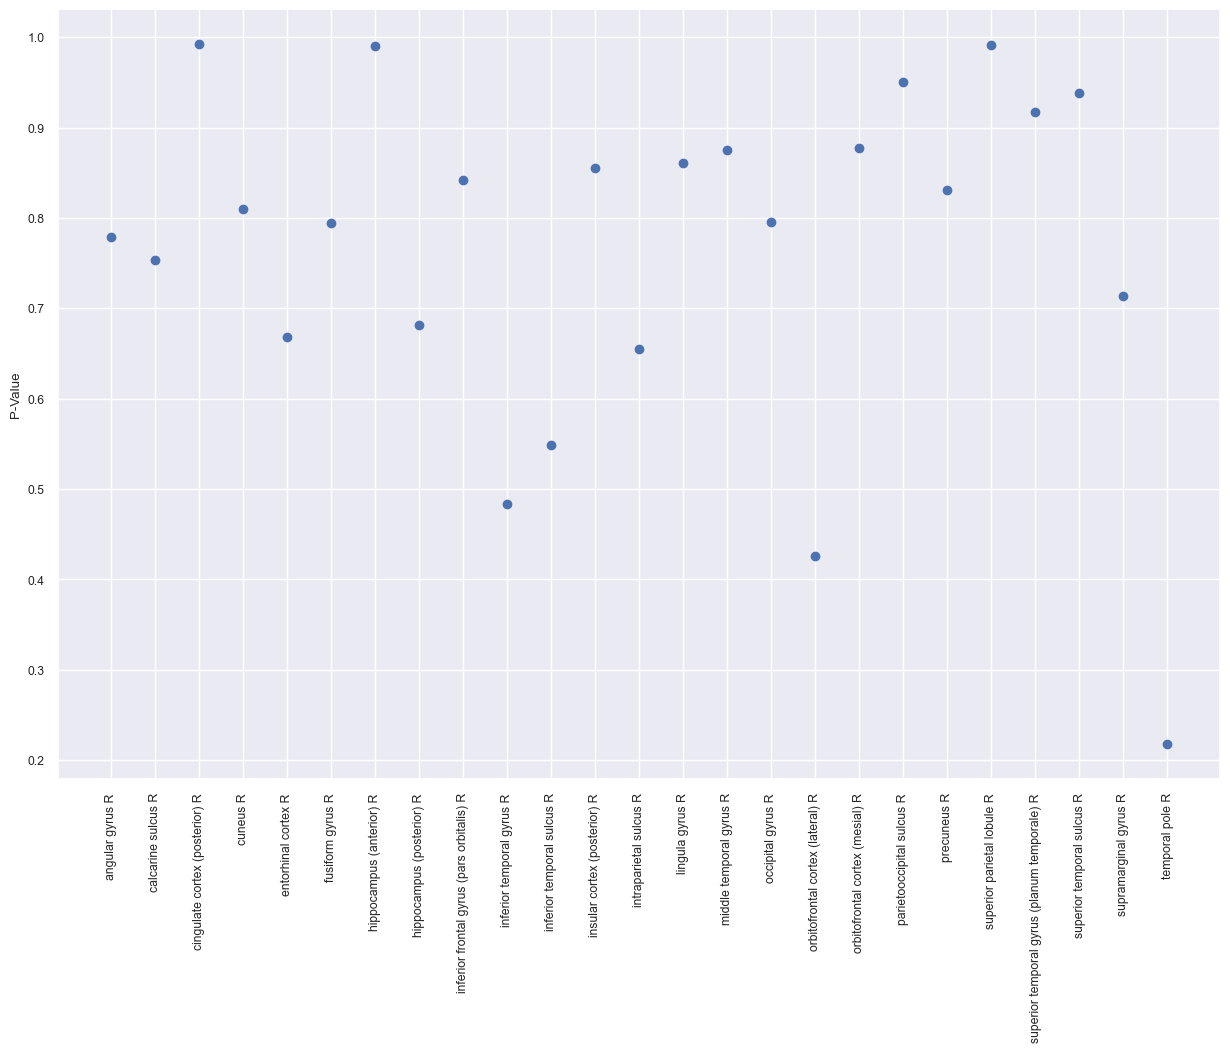

In [115]:
fig, axs = plt.subplots(1, figsize=(15,10))

axs.scatter(np.arange(len(unique_ch_areas)), p_vals)
axs.set_xticks(np.arange(len(unique_ch_areas)), labels=unique_ch_areas,rotation=90)
axs.set_ylabel('P-Value')

## LDA

In [116]:
SI_wins_high_bet.shape

(86, 75, 25)

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

## Plot sink index heatmap

In [40]:
SI_overalls = []

for A_hat in A_hat_all:
    # Computer A_mean over time wins
    A_mean = np.mean(A_hat, axis=2)
    SI_overall, _, _ = identifySS(A_mean)
    SI_overalls.append(SI_overall)

SI_overalls = np.asarray(SI_overalls)

SI_overalls_low_bet = SI_overalls[low_bet_trials,:].mean(axis=0)
SI_overalls_high_bet = SI_overalls[high_bet_trials,:].mean(axis=0)
SI_overalls_difference = SI_overalls_high_bet - SI_overalls_low_bet

SI_sort_idx_overall = np.argsort(SI_overalls.mean(0))
SI_wins_sorted = SI_wins_high_bet[0][SI_sort_idx_overall, :]
labels_sort = [filtered_elec_areas[i] + " | " + filtered_elec_names[i] for i in SI_sort_idx_overall]

In [37]:
# recording_len_sec = time_axis[-1]
t_W = np.arange(0, nWin, 1)
t_sec = np.arange(0, nWin*winSize/fs, 0.5)
# time_labs = [time_sum(rec_start_time, sec2time(t)) for t in t_sec]
# time_labs_gap = int(np.floor(recording_len_sec/20)) # 5 sec for example
t_W_fig = t_W.copy()
t_W_fig = t_W_fig[::30*2] - t_W_fig[0]
# time_labs_fig = time_labs # can be limited to fig_start_Wi:fig_end_Wi
# time_labs_fig = time_labs_fig[::30*2]

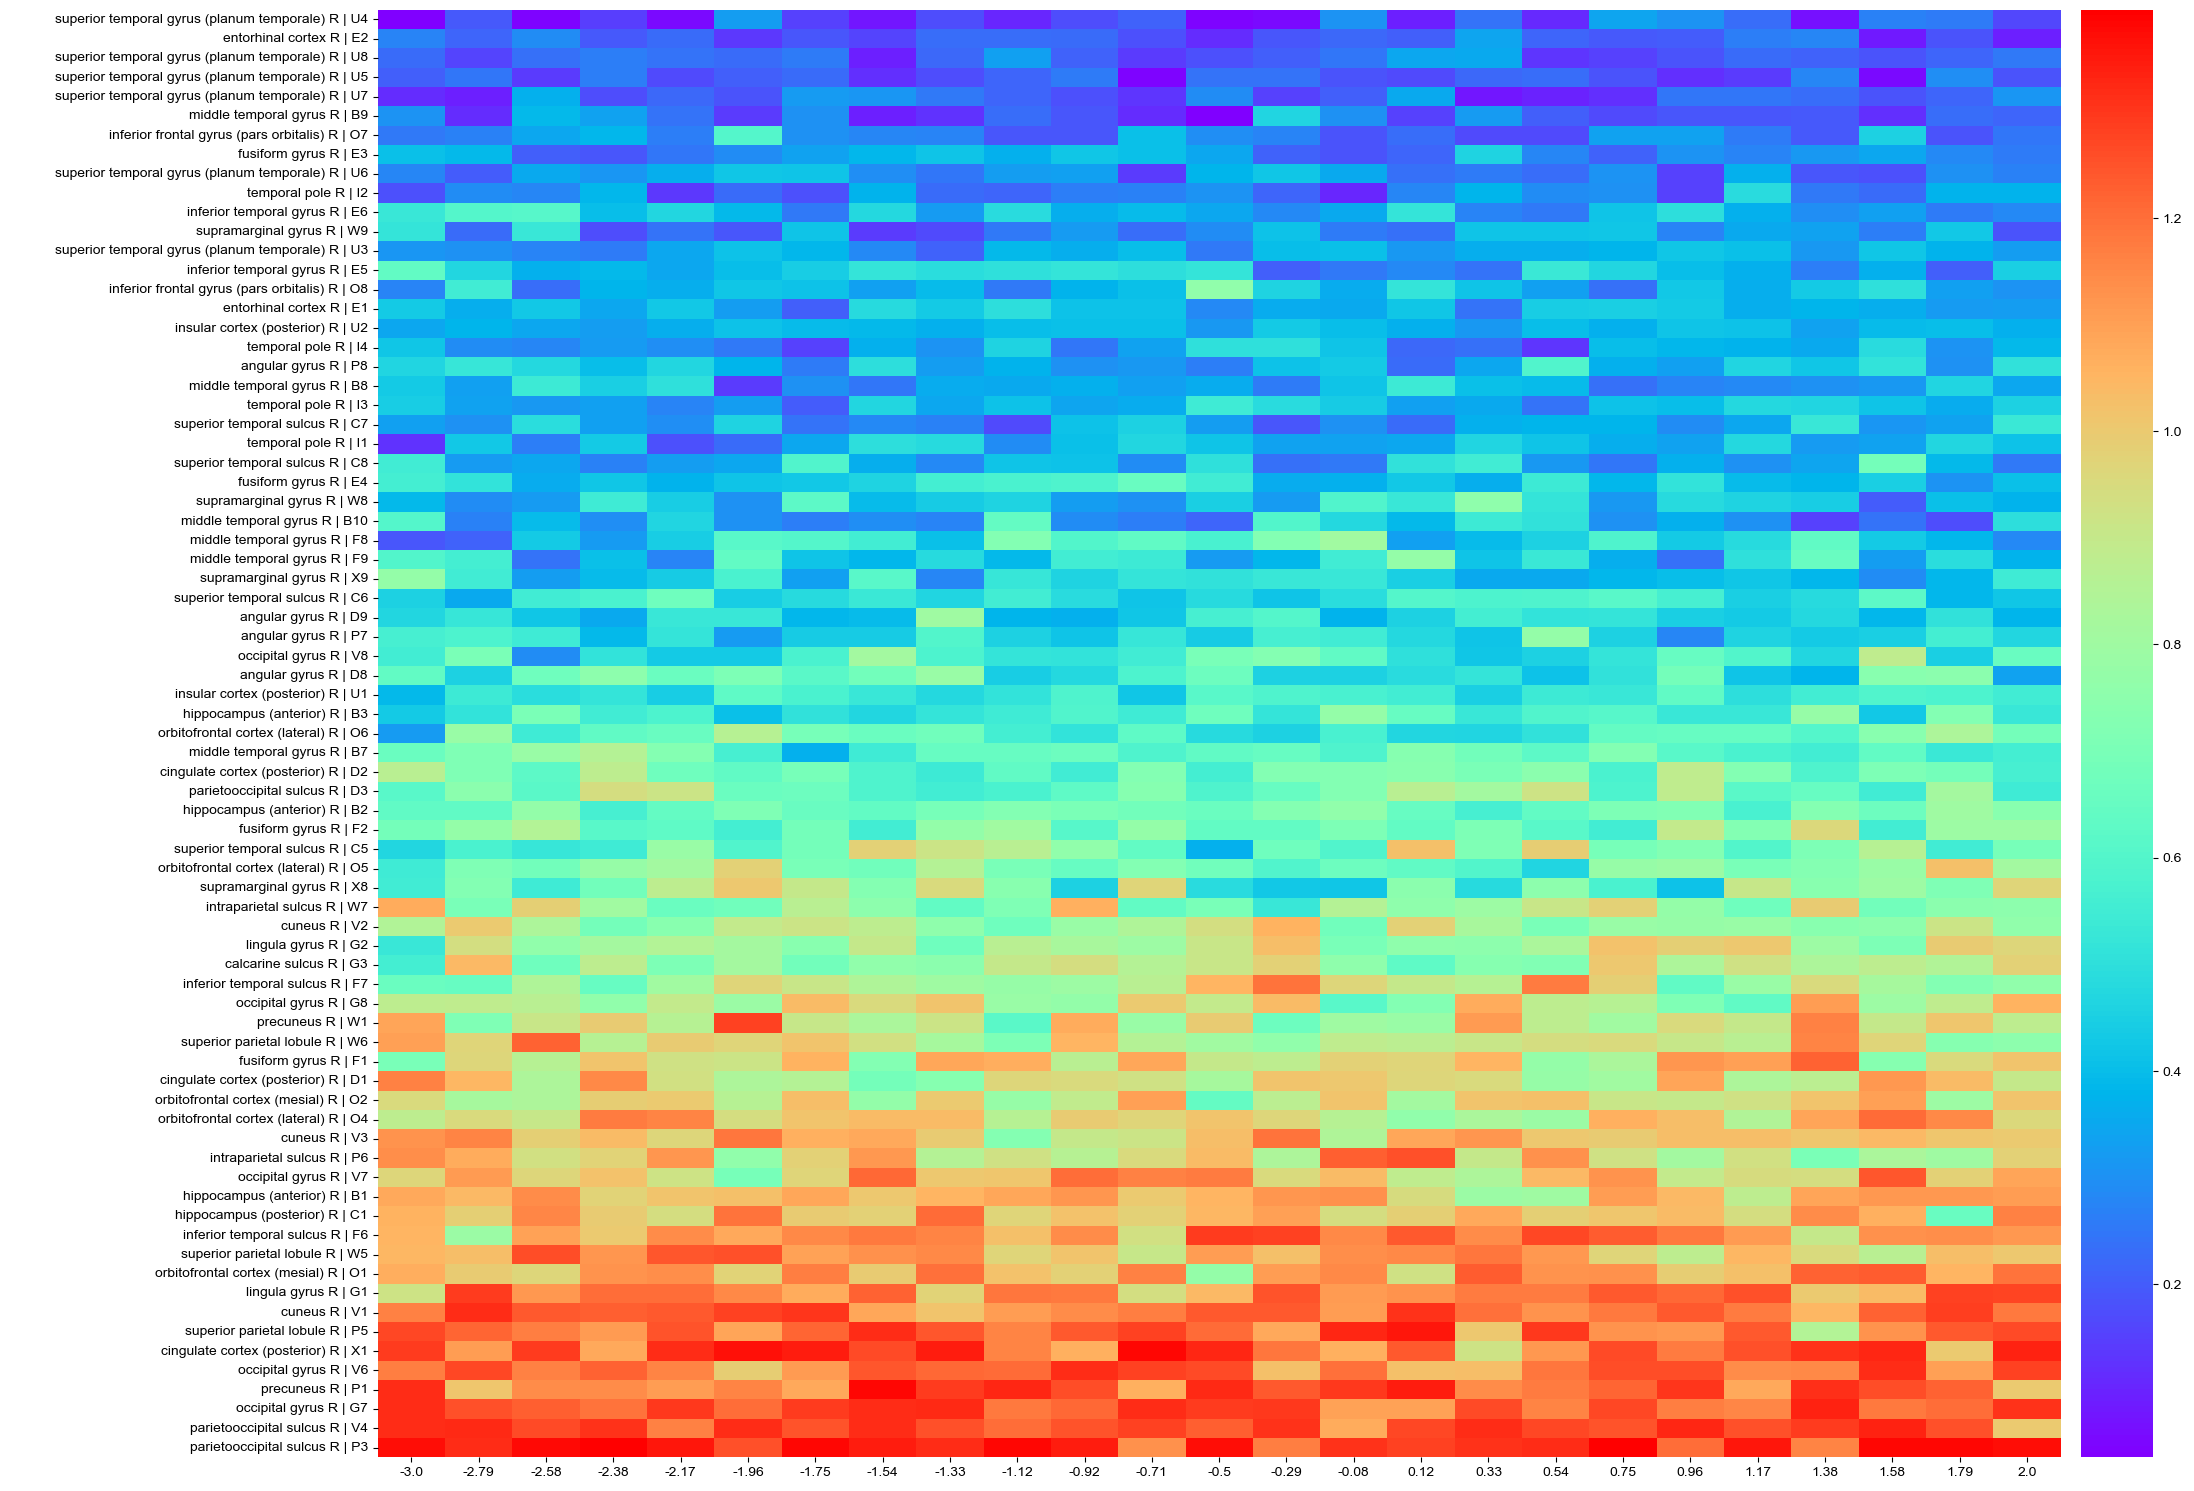

In [38]:
fig, ax = plt.subplots(1,1,figsize=(24, 15))
sns.heatmap(SI_wins_sorted, xticklabels=time, yticklabels=labels_sort,cmap=sns.color_palette("rainbow", as_cmap=True), cbar_kws={"pad": 0.01})
sns.set(font_scale=0.8)
# ax.set_xticks(t_W_fig)
# ax.set_xticklabels(time_labs_fig, rotation=70, fontsize=16)
# title = f'Folder {subject} - Recording {rec_label}\n' + \
#         f'Sink indices during a whole recording on {rec_start_date}\n' + \
#         f'From {rec_start_time} to {rec_stop_time}'
# ax.set_title(title, fontsize=25)
# ldg = plt.legend(fontsize=15, loc='lower right', facecolor='#fcfcfa')
plt.grid(False)
plt.tight_layout()
# if not exists(subject):
#     makedirs(subject)
# if not exists(f'{subject}\\{rec_label}'):
#     makedirs(f'{subject}\\{rec_label}')
# plt.savefig(f'{subject}\\{rec_label}\\{rec_label}-SI+heatmap.png', transparent=False, bbox_extra_artists=(ldg,), bbox_inches='tight')
plt.show()

# Compute spectral entropy

In [ ]:
from tqdm.auto import tqdm
from TorchSpectra import compute_spectrogram

minu = 0.05 # minutes of SItime_t to compute entropy
n = int(minu*60/winSize_sec)

varSE_all = np.zeros((nCh,nWin))

pbar = tqdm(total=nCh, desc='Percentage of entropies computed', position=0) # Daniel's suggestion
for chi in range(nCh):
    # pbar.set_postfix({'Channel': labels[chi]})

    SI_channel = SI_wins[chi,:]

    SI_channel = np.concatenate((np.zeros((n)), SI_channel))

    time_axis, frequency_axis, power_spectrogram = compute_spectrogram(input_vector=SI_channel, sample_rate=2, window_size=n, hop_size=1, n_fft=n, window_type="boxcar")

    power_spectrogram = power_spectrogram[:,:-1]

    psd = power_spectrogram[1:,:] # exclude DC
    with np.errstate(divide='ignore', invalid='ignore'):
        psd_norm = psd / psd.sum(axis=0, keepdims=True)
        psd_norm[psd_norm == np.inf] = 0
    se = -_xlogx(psd_norm).sum(axis=0) # Sum over all frequencies
    se /= np.log2(psd_norm.shape[0])

    varSE_all[chi, :] = se

    pbar.update(1) # DONE WITH COMPUTATION FOR CHANNEL {chi}
